In [1]:
# Header Files
import io
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import random
import warnings

import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

#from tqdm import tqdm 

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
#from keras.models import model_from_json

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
# Path Variables
INPUT_H5 = "road_256.h5"
MASKS_H5 = "mask_256.h5"
MODEL_H5 = "roads_weights_RESNET_50.h5"
MODEL_FINAL = "roads_weights_RESNET_FINAL_50.h5"

# Size Variables

IMG_SIZE = (256,256)
BATCH_SIZE = 64
EPOCHS = 50
SEED = 303

In [2]:
def getIOU(y_true, y_pred, smooth=1):
  tf.cast(y_true, tf.float32)
  tf.cast(y_pred, tf.float32)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

In [5]:
hf1 = h5py.File(INPUT_H5, 'r')
hf2 = h5py.File(MASKS_H5,'r')

input_image=[]
input_mask=[]

input_image = list(hf1.keys())
input_image = sorted(input_image)
#print(input_image)

input_mask = list(hf2.keys())
input_mask  = sorted(input_mask)
#print(input_mask)

print(len(input_image))
print(len(input_mask))

hf1.close()
hf2.close()

6226
6226


In [6]:
val_samples = 1522
random.Random(1337).shuffle(input_image)
random.Random(1337).shuffle(input_mask)

train_input_img_paths  =  input_image[:-val_samples]
train_target_img_paths =  input_mask[:-val_samples]
val_input_img_paths    =  input_image[-val_samples:]
val_target_img_paths   =  input_mask[-val_samples:]

train_input_img_paths=sorted(train_input_img_paths)
train_target_img_paths=sorted(train_target_img_paths)
val_input_img_paths=sorted(val_input_img_paths)
val_target_img_paths=sorted(val_target_img_paths)

In [7]:
class DataLoad(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x= np.zeros((self.batch_size, 256,256,3), dtype=np.uint8)
        for j, path in enumerate(batch_input_img_paths):
            h5 = h5py.File(INPUT_H5, 'r')
            data=h5.get(path)
            data=np.array(data)
            img = Image.open(io.BytesIO(data))
            img=np.array(img)
            img=resize(img, (256,256), mode='constant',  preserve_range=True)
            x[j] = img
        
        y=np.zeros((self.batch_size, 256, 256, 1), dtype=np.bool)
        for j, path in enumerate(batch_target_img_paths):
            mask = np.zeros((256,256, 1), dtype=np.bool)
            h51=h5py.File(MASKS_H5,'r')
            data=h51.get(path)
            data=np.array(data)
            mask_=Image.open(io.BytesIO(data))
            
            mask_=np.array(mask_)
            mask_ = np.expand_dims(resize(mask_, (256,256), mode='constant',preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_) 
            y[j]=mask
            
           
        return x, y
    




train_gen = DataLoad(BATCH_SIZE, IMG_SIZE, train_input_img_paths, train_target_img_paths)
val_gen = DataLoad(BATCH_SIZE, IMG_SIZE, val_input_img_paths, val_target_img_paths)

print(len(train_gen))
print(len(val_gen))

73
23


In [8]:
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

NUM_CLASSES = 1
OPTIMIZER = 'adam'

#BUILD THE U-NET MODEL
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


In [10]:
def uNet(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, nclasses=NUM_CLASSES, filters=16):
    # Contraction Path
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
    
    # Expansion Path
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)

    # output
    output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('sigmoid')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    
    return model

In [11]:
resnet = tf.keras.applications.ResNet101(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3),
        pooling=max
    )
# FREEZE layers
resnet.trainable = False

def uNetResnet(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, nclasses=NUM_CLASSES, filters=64):
    input_layer = resnet.input
    
    # Contraction path
    conv1 = resnet.get_layer('conv1_relu').output # 64 filters
    conv2 = resnet.get_layer('conv2_block3_out').output # 256
    conv3 = resnet.get_layer('conv3_block4_out').output # 512
    conv4 = resnet.get_layer('conv4_block23_out').output # 1024
    conv5 = resnet.get_layer('conv5_block3_out').output # 2048
    conv5 = Dropout(0.5)(conv5)
    
    # Expansion Path
    deconv4 = deconv_block(conv5, residual=conv4, nfilters=filters*16)
    deconv4 = Dropout(0.3)(deconv4)
    deconv3 = deconv_block(deconv4, residual=conv3, nfilters=filters*8)
    deconv3 = Dropout(0.5)(deconv3)
    deconv2 = deconv_block(deconv3, residual=conv2, nfilters=filters*4)
    deconv1 = deconv_block(deconv2, residual=conv1, nfilters=filters)
    
    # Output
    output_layer = Conv2DTranspose(filters//2, kernel_size=(3, 3), strides=(2, 2), padding='same')(deconv1)
    output_layer = conv_block(output_layer, nfilters=filters//4)
    output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1, 1))(output_layer)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('sigmoid')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='UnetResnet')
    return model



In [12]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(MODEL_H5, verbose=1, save_best_only=True)]

In [13]:
#model = uNet()
model = uNetResnet()
model.summary()

# Compile if any of above fresh models are used
model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy',getIOU])

#model = load_model("resnet_adam_50epochs.h5")

# Uncomment line below when fine tuning
#model.trainable = True

Model: "UnetResnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________________________

In [14]:
results = model.fit(train_gen,epochs=EPOCHS,batch_size=BATCH_SIZE, validation_data=val_gen,callbacks=callbacks)
print(results)

model.save(MODEL_FINAL)
print("Model Saved")

Epoch 1/50
73/73 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.8691 - getIOU: 0.1012
Epoch 00001: val_loss improved from inf to 0.80931, saving model to roads_weights_RESNET_50.h5
73/73 [==============================] - 71s 975ms/step - loss: 0.6161 - accuracy: 0.8691 - getIOU: 0.1012 - val_loss: 0.8093 - val_accuracy: 0.7222 - val_getIOU: 0.1028
Epoch 2/50
73/73 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.9032 - getIOU: 0.1108
Epoch 00002: val_loss improved from 0.80931 to 0.53534, saving model to roads_weights_RESNET_50.h5
73/73 [==============================] - 74s 1s/step - loss: 0.5612 - accuracy: 0.9032 - getIOU: 0.1108 - val_loss: 0.5353 - val_accuracy: 0.9404 - val_getIOU: 0.0837
Epoch 3/50
73/73 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.9189 - getIOU: 0.1165
Epoch 00003: val_loss improved from 0.53534 to 0.48164, saving model to roads_weights_RESNET_50.h5
73/73 [==============================

Epoch 46/50
73/73 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9899 - getIOU: 0.4610
Epoch 00046: val_loss did not improve from 0.17968
73/73 [==============================] - 65s 892ms/step - loss: 0.0686 - accuracy: 0.9899 - getIOU: 0.4610 - val_loss: 0.1809 - val_accuracy: 0.9594 - val_getIOU: 0.3242
Epoch 47/50
73/73 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9901 - getIOU: 0.4695
Epoch 00047: val_loss did not improve from 0.17968
73/73 [==============================] - 66s 910ms/step - loss: 0.0663 - accuracy: 0.9901 - getIOU: 0.4695 - val_loss: 0.1822 - val_accuracy: 0.9587 - val_getIOU: 0.3294
Epoch 48/50
73/73 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9902 - getIOU: 0.4762
Epoch 00048: val_loss improved from 0.17968 to 0.17865, saving model to roads_weights_RESNET_50.h5
73/73 [==============================] - 74s 1s/step - loss: 0.0646 - accuracy: 0.9902 - getIOU: 0.4762 - val_loss: 0.1787 

In [7]:
from tensorflow.keras.models import load_model
model = load_model('roads_weights_RESNET_FINAL_50.h5',custom_objects={'getIOU':getIOU})
print('Model Loadedd')

Model Loadedd


In [8]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import h5py
import matplotlib.pyplot as plt
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

In [9]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import h5py
import matplotlib.pyplot as plt

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F2E0435E2B0>


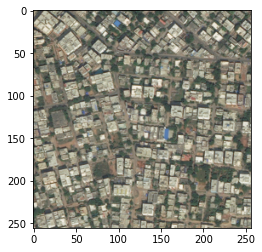

In [27]:
X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
img=Image.open('54778_sat.jpg')
img = img.resize((256, 256))
print(img)
plt.imshow(img)
img=np.array(img)
X_test[0] = img

In [28]:
preds_test=model.predict(X_test, verbose=1)
print('Prediction:- ')
print(preds_test)
print(preds_test.shape)
print(preds_test.max(),preds_test.min())

1/1 [==============================] - 0s 1ms/step
Prediction:- 
[[[[0.1779714 ]
   [0.28597623]
   [0.31659618]
   ...
   [0.9605701 ]
   [0.9812517 ]
   [0.93826395]]

  [[0.27618945]
   [0.3978114 ]
   [0.41449746]
   ...
   [0.9970066 ]
   [0.99718875]
   [0.96435535]]

  [[0.24019548]
   [0.40799248]
   [0.656711  ]
   ...
   [0.99474055]
   [0.9969145 ]
   [0.96537405]]

  ...

  [[0.2858309 ]
   [0.49952093]
   [0.5609355 ]
   ...
   [0.1264389 ]
   [0.1354674 ]
   [0.12861118]]

  [[0.3204439 ]
   [0.6602984 ]
   [0.64642924]
   ...
   [0.1890745 ]
   [0.18790688]
   [0.1606521 ]]

  [[0.19585097]
   [0.72534406]
   [0.8097638 ]
   ...
   [0.18131402]
   [0.1660509 ]
   [0.17823894]]]]
(1, 256, 256, 1)
1.0 0.027613103


In [29]:
preds_test = (preds_test > 0.5).astype(np.uint8)
print('Prediction:- ')
print(preds_test)
print(preds_test.shape)
print(preds_test.max(),preds_test.min())

Prediction:- 
[[[[0]
   [0]
   [0]
   ...
   [1]
   [1]
   [1]]

  [[0]
   [0]
   [0]
   ...
   [1]
   [1]
   [1]]

  [[0]
   [0]
   [1]
   ...
   [1]
   [1]
   [1]]

  ...

  [[0]
   [0]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]]
(1, 256, 256, 1)
1 0


In [30]:
mask=preds_test[0]
print('Mask:-')
print(mask)
print(mask.shape)
print(mask.max(),mask.min())

for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i][j] == 1:
                    mask[i][j] = 255
                else:
                    mask[i][j] = 0

Mask:-
[[[0]
  [0]
  [0]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [0]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[0]
  [0]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]]
(256, 256, 1)
1 0


Output Image:- 
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(256, 256, 3)


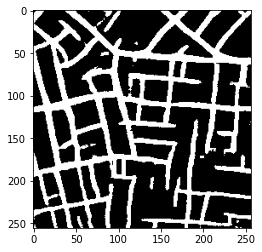

In [31]:
merged_image = cv2.merge((mask,mask,mask))
print('Output Image:- ')
print(merged_image)
print(merged_image.shape)
img=Image.fromarray(merged_image)
img.save('54778_mask.jpg')
plt.imshow(img)

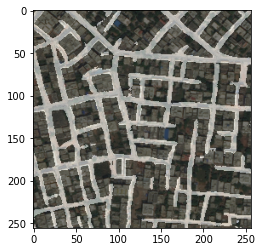

In [32]:
bg=Image.open('54778_sat.jpg')
bg=bg.resize((256,256))
overlay=Image.open('54778_mask.jpg')
bg=bg.convert('RGBA')
overlay=overlay.convert('RGBA')
new_image=Image.blend(bg,overlay,0.5)
new_image.save('merge','PNG')
plt.imshow(new_image)